In [2]:
#from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
from layers import conv_layer, max_pool_2x2, full_layer

DATA_DIR = '/tmp/data'
MINIBATCH_SIZE = 50
STEPS = 5000


actual_position = os.getcwd()
test_path  = actual_position + "/TF_Images/test/"
train_path = actual_position + "/TF_Images/train/"

def Label_Images(test_path,train_path):
    
    path_length_test   = len(test_path)
    path_length_train  = len(train_path)
    
    # schleife für test-Bilder
    data_path_test = os.path.join(test_path,'*g')     #  ???
    files_test = glob.glob(data_path_test)
    
    with open(test_path + "testlabels.txt", "w") as w_txtfile:
        for i,f1 in enumerate(files_test):
        
            img_name = f1[path_length_test:]
            label = int(img_name[:2])
            w_txtfile.write(str(label)+"\n")
    
    
    data_path_test = os.path.join(train_path,'*g')     #  ???
    files_train = glob.glob(data_path_test)
    
    with open(train_path + "trainlabels.txt", "w") as w_txtfile:
        for i,f1 in enumerate(files_train):
        
            img_name = f1[path_length_train:]
            label = int(img_name[:2])
            w_txtfile.write(str(label)+"\n")
            
    
Label_Images(test_path = test_path,train_path=train_path)


def next_batch(path, size, GRBtoGray=False, flatten=False):
    labels = []
    with open(path + "trainlabels.txt", "r") as r_txtfile:
        labels = r_txtfile.read().splitlines()
        labels = np.array(labels)  # noch als strings
    
    larry = np.array(labels).astype(np.uint8).reshape(( len(labels),1))
    label_binar = np.unpackbits(larry, axis=1)
    label_binar = np.delete(label_binar, np.s_[:6], 1)
    
    data_path = os.path.join(path, '*g')  # ???
    files = glob.glob(data_path)
    num_imag = len(files)
    Data = np.arange(0, num_imag)
    batchindices = np.random.choice(Data, size=size,
                                    replace=False)  # Zufallsstichprobe; reihenfolge beliebig; ohne zurückl.
    label_binar = label_binar[:][batchindices]


    img_list = []
    for i, f1 in enumerate(files):
        if i in batchindices:
            if GRBtoGray == True:
                img = cv2.imread(f1, flags=0)
            else:
                img = cv2.imread(f1, flags=1)

            if flatten == True:
                img_list.append(img.flatten())
            else:
                img_list.append(img)

    img_list = np.array(img_list)
    #  img_list = np.reshape(img_list,(size,50*50,))

    return img_list, label_binar




def test_images(path, size, GRBtoGray=False, flatten=False):
    labels = []
    with open(path + "testlabels.txt", "r") as r_txtfile:
        labels = r_txtfile.read().splitlines()
        labels = np.array(labels)  # noch als strings
    larry = np.array(labels).astype(np.uint8).reshape(( len(labels),1))
    label_binar = np.unpackbits(larry, axis=1)
    label_binar = np.delete(label_binar, np.s_[:6], 1)
    
    data_path = os.path.join(path, '*g')  # ???
    files = glob.glob(data_path)
    num_imag = len(files)
    Data = np.arange(0, num_imag)
    batchindices = np.random.choice(Data, size=size,
                                    replace=False)  # Zufallsstichprobe; reihenfolge beliebig; ohne zurückl.
    label_binar = label_binar[:][batchindices]


    img_list = []
    for i, f1 in enumerate(files):
        if i in batchindices:
            if GRBtoGray == True:
                img = cv2.imread(f1, flags=0)
            else:
                img = cv2.imread(f1, flags=1)

            if flatten == True:
                img_list.append(img.flatten())
            else:
                img_list.append(img)

    img_list = np.array(img_list)

    return img_list, label_binar

In [3]:
Label_Images(test_path,train_path)

In [4]:


try:
    print('closing session')
    sess.close

except:
    None

#mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)

x = tf.placeholder(tf.float32, shape=[None, 28, 28, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 2])

#x_image = tf.reshape(x, [-1, 28, 28, 1])
conv1 = conv_layer(x, shape=[3, 3, 3, 64])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[3, 3, 64, 128])
conv2_pool = max_pool_2x2(conv2)

conv2_flat = tf.reshape(conv2_pool, [-1, 7*7*128])
full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

keep_prob = tf.placeholder(tf.float32)
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 2)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#with tf.Session() as sess:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(STEPS):
    X_batch, y_batch = next_batch(path=train_path, size=MINIBATCH_SIZE, GRBtoGray=False, flatten=False)


    #batch = .train.next_batch(MINIBATCH_SIZE)

    if i % 100 == 0:
    #    train_accuracy = sess.run(accuracy, feed_dict={x: batch[0], y_: batch[1],
    #                                                   keep_prob: 1.0})
        train_accuracy = sess.run(accuracy, feed_dict={x: X_batch, y_: y_batch,
                                                       keep_prob: 1.0})
        print("step {}, training accuracy {}".format(i, train_accuracy))

    sess.run(train_step, feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.8})

X_batch, y_batch = test_images(path=test_path, size=MINIBATCH_SIZE, GRBtoGray=False, flatten=False)

test_accuracy = np.mean([sess.run(accuracy, feed_dict={x: X_batch, y_: y_batch, keep_prob: 1.0}) for i in range(10)])

# X_batch, y_batch = test_images(path=test_path, size=1, GRBtoGray=True, flatten=False)
#X_batch = np.expand_dims(X_batch, axis=3)
#y_batch = np.expand_dims(y_batch, axis=1)
#print(sess.run(tf.cast(correct_prediction, tf.float32), feed_dict={x: X_batch[0], y_: y_batch[0], keep_prob: 1.0}))

print("test accuracy: {}".format(test_accuracy))

closing session
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

step 0, training accuracy 0.4000000059604645
step 100, training accuracy 0.5400000214576721
step 200, training accuracy 0.4000000059604645
step 300, training accuracy 0.5400000214576721
step 400, training accuracy 0.5
step 500, training accuracy 0.6000000238418579
step 600, training accuracy 0.47999998927116394
step 700, training accuracy 0.4000000059604645
step 800, training accuracy 0.5199999809265137
step 900, training accuracy 0.5400000214576721
step 1000, training accuracy 0.5400000214576721
step 1100, training accuracy 0.3799999952316284
step 1200, training accuracy 0.3799999952316284
step 1300, training accuracy 0.5199999809265137
step 1400, training accuracy 0.47999998927116394
step 1500, training accuracy 0.5
step 1600, training accuracy 0.47999998927116394
step 1700, trai

In [5]:
save_path = saver.save(sess, actual_position + "/model2.ckpt")
print ("Model saved in file: ", save_path)

NameError: name 'saver' is not defined

In [12]:

X_batch, y_batch = test_images(path=test_path, size=1, GRBtoGray=False, flatten=False)
pred = sess.run(tf.cast(correct_prediction, tf.float32), feed_dict={x: X_batch, y_: y_batch, keep_prob: 1.0})

In [23]:
np.binary_repr(0, 2)

'00'

[0.]


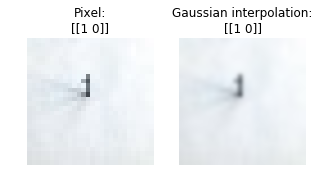

[1.]


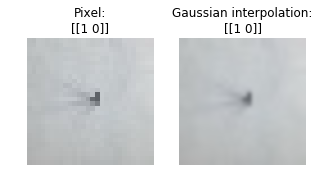

[1.]


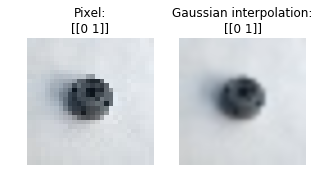

[0.]


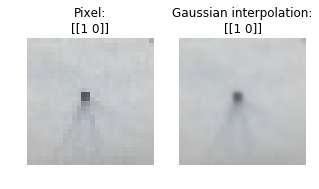

[0.]


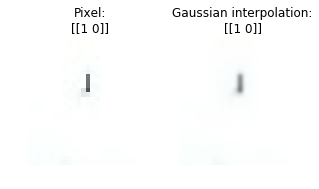

[1.]


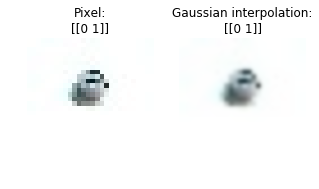

[0.]


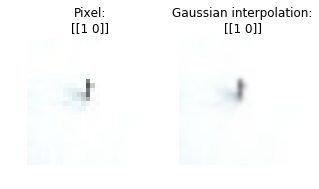

[1.]


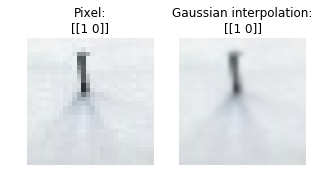

[1.]


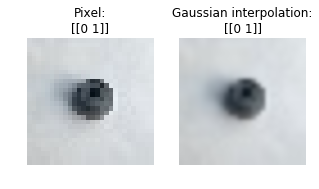

[0.]


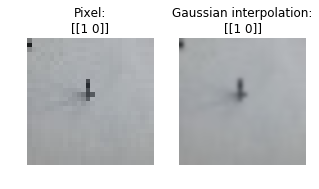

[0.]


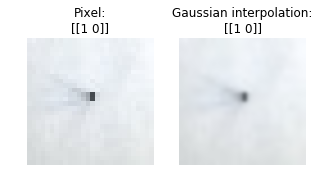

[0.]


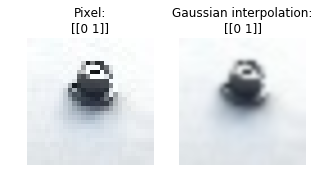

[1.]


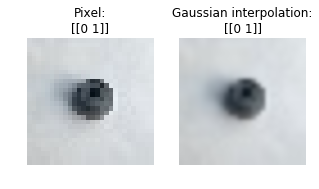

[1.]


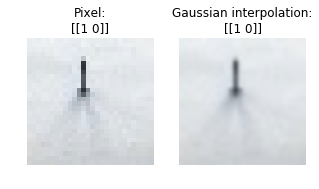

[1.]


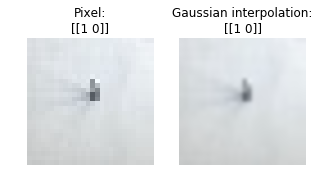

[1.]


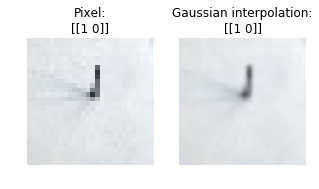

[0.]


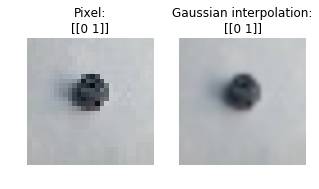

[0.]


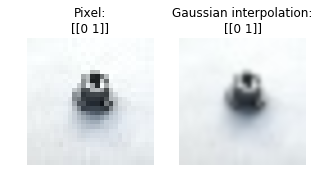

[1.]


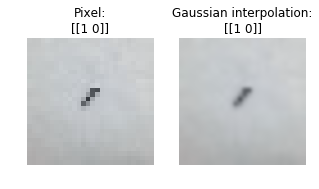

[1.]


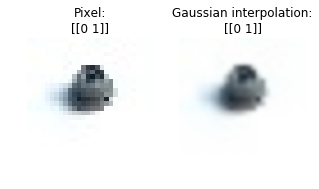

In [33]:
i = 0
while i < 20:
    i =i+1 
    
    X_batch, y_batch = test_images(path=test_path, size=1, GRBtoGray=False, flatten=False)
    label = y_batch
    image_ar = X_batch[0]

    print(sess.run(tf.cast(correct_prediction, tf.float32), feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.1}))




    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.axis('off')
    ax1.set_title('Pixel:\n' + str(label))
    ax1.imshow(image_ar, cmap='gray');
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.axis('off')
    ax2.set_title('Gaussian interpolation:\n' + str(label))
    ax2.imshow(image_ar, cmap='gray', interpolation="gaussian");
    plt.show()

In [19]:

#import modules
import sys
import tensorflow as tf

def predictint(imvalue):
    """
    This function returns the predicted integer.
    The input is the pixel values from the imageprepare() function.
    """
    
    # Define the model (same as when creating the model file)
    x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1])
    y_ = tf.placeholder(tf.float32, shape=[None, 1])

    #x_image = tf.reshape(x, [-1, 28, 28, 1])
    conv1 = conv_layer(x, shape=[5, 5, 1, 32])
    conv1_pool = max_pool_2x2(conv1)

    conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
    conv2_pool = max_pool_2x2(conv2)

    conv2_flat = tf.reshape(conv2_pool, [-1, 7*7*64])
    full_1 = tf.nn.relu(full_layer(conv2_flat, 1024))

    keep_prob = tf.placeholder(tf.float32)
    full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

    y_conv = full_layer(full1_drop, 1)


    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
    """
    Load the model.ckpt file
    file is stored in the same directory as this python script is started
    Use the model to predict the integer. Integer is returend as list.
    Based on the documentatoin at
    https://www.tensorflow.org/versions/master/how_tos/variables/index.html
    """
    with tf.Session() as sess:
        sess.run(init_op)
        saver.restore(sess, save_path)
        print ("Model restored.")
   
        prediction=tf.argmax(y_conv,1)
        return prediction.eval(feed_dict={x: [imvalue]},keep_prob=1.0, session=sess)

X_batch, y_batch = test_images(path=test_path, size=1, GRBtoGray=True, flatten=False)

    
predint = predictint(X_batch)
print (predint[0]) #first value in list


INFO:tensorflow:Restoring parameters from /home/jeronimo/envs/CNN_mnist_test/model2.ckpt


NotFoundError: Key Variable_32 not found in checkpoint
	 [[Node: save_3/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_3/Const_0_0, save_3/RestoreV2/tensor_names, save_3/RestoreV2/shape_and_slices)]]

Caused by op 'save_3/RestoreV2', defined at:
  File "/usr/lib64/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib64/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-9ca5defd958f>", line 53, in <module>
    predint = predictint(X_batch)
  File "<ipython-input-19-9ca5defd958f>", line 33, in predictint
    saver = tf.train.Saver()
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1338, in __init__
    self.build()
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1347, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1384, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 835, in _build_internal
    restore_sequentially, reshape)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 472, in _AddRestoreOps
    restore_sequentially)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 886, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1463, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/jeronimo/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key Variable_32 not found in checkpoint
	 [[Node: save_3/RestoreV2 = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, ..., DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_3/Const_0_0, save_3/RestoreV2/tensor_names, save_3/RestoreV2/shape_and_slices)]]
